In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# ----- Parameters -----
DATA_DIR = "../Database/img/"
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001

In [3]:
# ----- Load Data -----
all_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
df_list = []

for file in all_files:
    path = os.path.join(DATA_DIR, file)
    df = pd.read_csv(path, header=None)
    label = file.split('.')[0].split('_')[0]
    df['label'] = label
    df_list.append(df)

data = pd.concat(df_list, ignore_index=True)
data.iloc[:, :-1] = data.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')
data = data.dropna().reset_index(drop=True)

X = data.iloc[:, :-1].astype(np.float32).values
y = data['label'].values

encoder = LabelEncoder()
y = encoder.fit_transform(y)

FileNotFoundError: [Errno 2] No such file or directory: '../Database/img/'

In [4]:
# ----- Train-test split -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

NameError: name 'X' is not defined

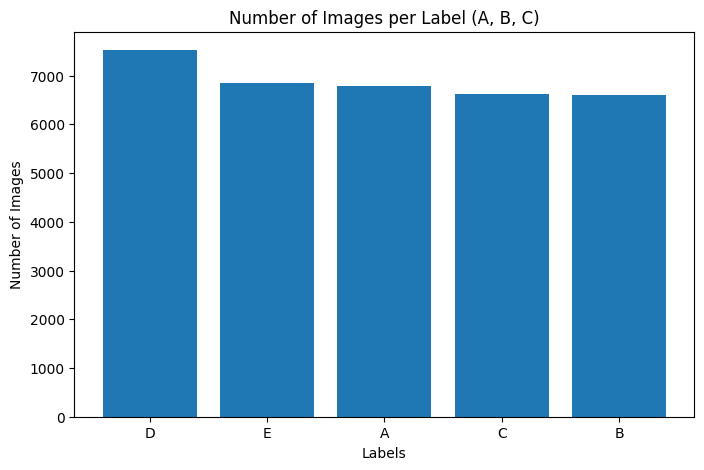

In [30]:
# ----- Convert to Torch tensors -----
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [31]:
# ----- DataLoaders -----
train_ds = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_ds = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
# ----- Model -----
model = nn.Sequential(
    nn.Linear(X.shape[1], 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, len(np.unique(y)))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [33]:
# ----- Loss & Optimizer -----
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [34]:
# ----- Training -----
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}")

/home/mush/git/github/Data-Glove/Model/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='ovr')

In [35]:
# ----- Evaluation -----
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

print("\nTest Accuracy:", accuracy_score(all_true, all_preds))
print("\nClassification Report:\n", classification_report(all_true, all_preds, target_names=encoder.classes_))

Test Accuracy: 0.3962758219377364

Classification Report:
               precision    recall  f1-score   support

           A       0.35      0.33      0.34      1356
           B       0.28      0.01      0.03      1319
           C       0.37      0.57      0.45      1324
           D       0.40      0.48      0.43      1505
           E       0.48      0.57      0.52      1370

    accuracy                           0.40      6874
   macro avg       0.37      0.39      0.35      6874
weighted avg       0.37      0.40      0.36      6874



In [36]:
# ----- Sample Predictions -----
sample_indices = np.random.choice(len(all_true), 10, replace=False)
for i in sample_indices:
    print(f"True: {encoder.classes_[all_true[i]]}, Predicted: {encoder.classes_[all_preds[i]]}")